In [ ]:
#Ionosphere dataset, 34 continuous variables with no missing values
#Binary Classification Problem(Good or Bad Radio Returns)
#https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.names
import tensorflow as tf
import datetime
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
!rm -rf ./logs/

In [ ]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
file = pd.read_csv(path, header=None)
#Check for empty entries
print(file.isna().sum())

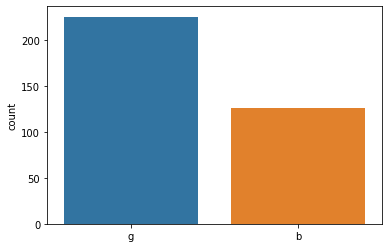

In [ ]:
#Check for imbalance
sns.countplot(x=file.values[:,-1], data=file)
#imbalance in amount of good and bad samples

In [ ]:
#Drop second column since it has no variance
file.drop(1, axis=1, inplace=True)
file

,0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,0.81197,0.06723,0.79307,-0.08929,1.00000,-0.02101,0.96639,0.06618,0.87605,0.01155,0.77521,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,g
347,1,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,0.94171,0.07330,0.94625,-0.01326,0.97173,0.00140,0.94834,0.06038,0.92670,0.08412,0.93124,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,g
348,1,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,0.92595,0.04688,0.93954,-0.01461,0.94837,0.02004,0.93784,0.01393,0.91406,0.07677,0.89470,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,g
349,1,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,0.89061,-0.01436,0.90608,-0.04530,0.91381,-0.00884,0.80773,-0.12928,0.88729,0.01215,0.92155,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,g


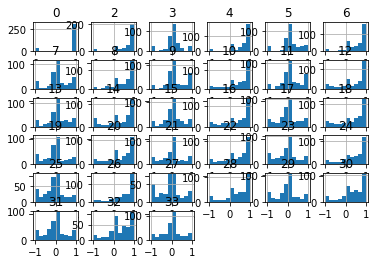

In [ ]:
#Check Gaussian Distribution
file.hist()
pyplot.show()
#Seems relatively normal distribution for most variables

In [ ]:
x,y = file.values[:,:-1], file.values[:,-1]
x = x.astype('float32')
y = LabelEncoder().fit_transform(y) #Turn categorical variable into binary representation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=1,stratify=y)

In [ ]:
#Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[:,1:] = scaler.fit_transform(x_train[:,1:])
x_test[:,1:] = scaler.fit_transform(x_test[:,1:])

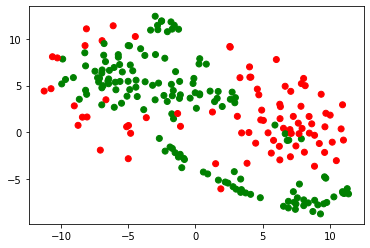

In [ ]:
#Data Visualization - TSNE
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

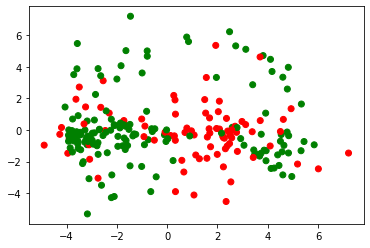

In [ ]:
#Data Visualization - PCA
from sklearn.decomposition import PCA

x_embedded = PCA(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

In [ ]:
iter = 50
batch_size = 32
n_features = x_train.shape[1] #33 features
scoring = "roc_auc"

In [ ]:
def mod():
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
network = mod()
fit = network.fit(x_train, y_train, epochs=iter, batch_size=batch_size, verbose=1, validation_data=(x_test,y_test))

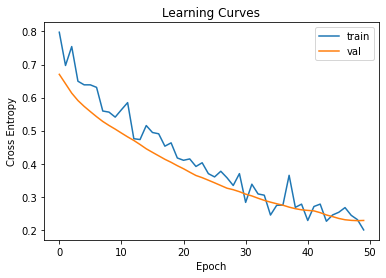

In [ ]:
#Plot learning curve to tune hyperparameters
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='val')
plt.legend()
plt.show()
#Training and Validation Cross Entropy Error seems to stablize at a low error with little gap between the two variables around ~30-50 Epoch range

In [ ]:
#KFold validation 
from keras.wrappers.scikit_learn import KerasClassifier

kfold = KFold(n_splits=10,shuffle=True,random_state=1)

model = KerasClassifier(build_fn = lambda: mod(), epochs=iter, batch_size=batch_size, verbose=0)
result = model_selection.cross_val_score(model,x,y,cv=kfold,scoring=scoring)
print('AUC: %.3f' % result.mean())
#AUC(.98>) Highly accurate

AUC: 0.984


In [ ]:
#Stratified KFold validation 
from keras.wrappers.scikit_learn import KerasClassifier

kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
model = mod()

model = KerasClassifier(build_fn = lambda: mod(), epochs=150, batch_size=32, verbose=0)

result = model_selection.cross_val_score(model,x,y,cv=kfold,scoring=scoring)
print('AUC: %.3f' % result.mean())
#AUC(.99>) Highly accurate

AUC: 0.990


In [ ]:
#round predicted results for metrics
predicted = network.predict(x_test)
predicted = np.round(predicted)

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)
#False postives and False negatives around same size
#and are quite small
#Model is accurately classifiying good and bad radio waves

array([[34,  8],
       [ 3, 71]])

In [ ]:
#Classification report
from sklearn.metrics import classification_report
#0 - bad radio waves
#1 - good radio waves
report = classification_report(y_test, predicted,output_dict=True)
report
#Macro avg 
#f1 score ~.9 
#precision ~90%
#recall ~89%
#Dataset split looks to be fairly balanced between good and bad radio samples
#Weighted avg
#f1 score ~.9
#precision ~91%
#recall ~91%
#Model seems to perform accurate classifciation(90%>) of good and bad radio samples 

{'0': {'f1-score': 0.860759493670886,
  'precision': 0.918918918918919,
  'recall': 0.8095238095238095,
  'support': 42},
 '1': {'f1-score': 0.9281045751633986,
  'precision': 0.8987341772151899,
  'recall': 0.9594594594594594,
  'support': 74},
 'accuracy': 0.9051724137931034,
 'macro avg': {'f1-score': 0.8944320344171424,
  'precision': 0.9088265480670544,
  'recall': 0.8844916344916345,
  'support': 116},
 'weighted avg': {'f1-score': 0.9037210111747302,
  'precision': 0.9060424457630918,
  'recall': 0.9051724137931034,
  'support': 116}}